# AIML338, Time Series Analysis
### Lennox Crowe | Assignment 2

https://arxiv.org/pdf/2408.16187

### Task 0: Data exploration (NZEP)
**Objective:** Visualise selected segments of the data to observe and understand its characteristics.
**Output:** A concise analysis of the NZEP dataset to facilitate its use in the remainder of the assignment.

POCs (Point Of Connection): WWD1102, WWD1103


In [1]:
from numpy.ma.extras import average

from dataset_generation import get_electricityprice_data
from datetime import date, datetime
import pandas as pd
import pytz
import numpy as np

I wrote a function in `dataset_generation.py` which retrieves all data within a date range for a set of PointOfConnection ids. The dataset is cached after it is downloaded once. For this EDA, I am going to focus on the last year of data at the makara wind farm.

In [2]:
df_raw = get_electricityprice_data(start_date = date(2024, 8, 10), end_date = date(2025, 8, 10), poc=["WWD1102", "WWD1103"])

Check that the data has been loaded:

In [3]:
df_raw.head()

,TradingDate,TradingPeriod,PublishDateTime,PointOfConnection,Island,IsProxyPriceFlag,DollarsPerMegawattHour
0,2024-08-10,1,2024-08-10T00:00:00.000+12:00,WWD1102,NI,N,834.55
1,2024-08-10,1,2024-08-10T00:00:00.000+12:00,WWD1103,NI,N,834.55
2,2024-08-10,1,2024-08-10T00:04:42.000+12:00,WWD1102,NI,N,831.84
3,2024-08-10,1,2024-08-10T00:04:42.000+12:00,WWD1103,NI,N,831.84
4,2024-08-10,1,2024-08-10T00:09:33.000+12:00,WWD1102,NI,N,833.55


In [4]:
data_start = df_raw["PublishDateTime"].min()
data_end = df_raw["PublishDateTime"].max()

print("Minimum timestamp: " + str(data_start))
print("Maximum timestamp: " + str(data_end))

Minimum timestamp: 2024-08-10T00:00:00.000+12:00
Maximum timestamp: 2025-08-10T23:54:31.000+12:00


The publish date time will need to be converted to a datetime object.

In [5]:
df_raw["time"] = (pd.to_datetime(df_raw["PublishDateTime"], utc=True))

In [6]:
import matplotlib.pyplot as plt

In [7]:
df_makara_1 = df_raw[df_raw["PointOfConnection"] == "WWD1102"]
df_makara_2 = df_raw[df_raw["PointOfConnection"] == "WWD1103"]

### Check the pricing data and compare the two Point of Connections

Plot the entire time series to check for outliers, seasonality etc.

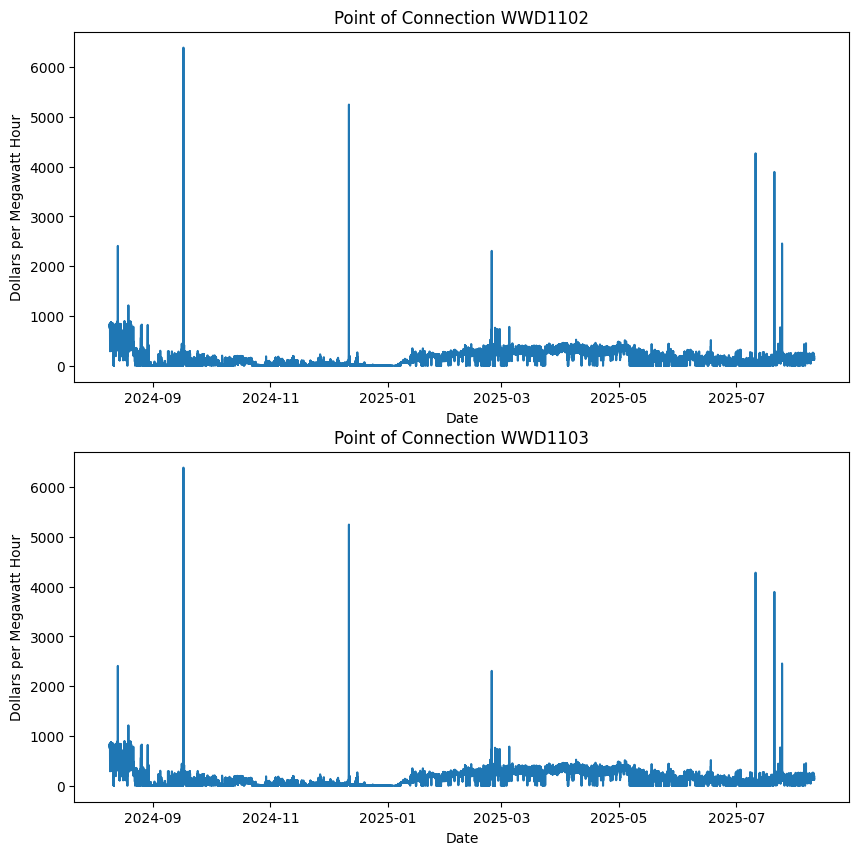

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10,10))

axes[0].plot(df_makara_1["time"], df_makara_1["DollarsPerMegawattHour"])
axes[0].set_title("Point of Connection WWD1102")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Dollars per Megawatt Hour")

axes[1].plot(df_makara_2["time"], df_makara_2["DollarsPerMegawattHour"])
axes[1].set_title("Point of Connection WWD1103")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Dollars per Megawatt Hour")

plt.show()

It appears that both connection points have the same pricing information, so we will continue the analysis looking at just WWD1102.

In [9]:
df_points = df_makara_1[["TradingPeriod", "DollarsPerMegawattHour", "time"]].copy()
df_points["time"] = pd.to_datetime(df_points["time"], utc=True)
df_points = df_points.sort_values("time")

## Validating the intervals between samples
Most time series models will require equal durations between samples. Validate that this is observed in this dataset.

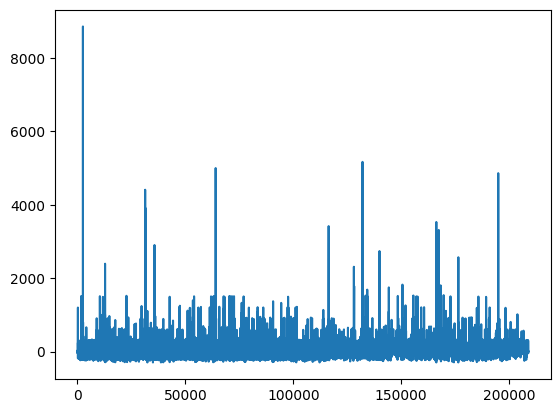

In [10]:
gaps = ((df_points["time"].astype(int)) - (df_points["time"].shift(1).astype(int)))
gaps = (gaps[gaps > 0]/1000000000)
plt.plot(gaps - 300)

There are large inconsistencies in the gaps between samples. This will need to be handled before further analysis.

The plot above displays the time difference between adjacent datapoints, minus the expected interval of 300 seconds (5 minutes). Negative values arrived early, while high values are likely due to gaps in the dataset (due to measurement errors, network outages etc).

In [11]:
print(f"Samples with missing data over 30 mins: {len(gaps[gaps > 60*30])}")
print(f"Samples with missing data over 60 mins: {len(gaps[gaps > 60*60])}")
print(f"Samples with missing data over 120 mins: {len(gaps[gaps > 60*120])}")

Samples with missing data over 30 mins: 40
Samples with missing data over 60 mins: 9
Samples with missing data over 120 mins: 1


Strategy: Make a forecast for each trading period. Take the average value over each trading period. Intervals will be spaced by exactly 30 mins.

In [12]:
dates_df = pd.DataFrame(pd.date_range(start=data_start, end=data_end), columns=["date"])

periods = pd.DataFrame(range(1, 48+1), columns=["TradingPeriod"])

dates_df = dates_df.join(periods, how="cross")
dates_df["date"] = dates_df["date"].dt.date

df_points["date"] = df_points["time"].dt.date

df_complete = pd.merge(df_points, dates_df, how="outer", on=["date", "TradingPeriod"])

df_grouped = (
    df_complete
    .groupby(["date", "TradingPeriod"], as_index=False)
    .agg({
        "DollarsPerMegawattHour": "mean"
    })
)

df_grouped["date"] = pd.to_datetime(df_grouped["date"])

df_grouped["start_time"] = df_grouped["date"] + pd.to_timedelta((df_grouped["TradingPeriod"] - 1) * 30, unit="m")
df_grouped["end_time"] = df_grouped["start_time"] + pd.Timedelta(minutes=30)

df_grouped.isna().sum()

date                       0
TradingPeriod              0
DollarsPerMegawattHour    47
start_time                 0
end_time                   0
dtype: int64

There are 47 missing values. Lets handle these later.

## Feature Engineering

Wind data has been obtained from NIWA: https://data.niwa.co.nz/products/climate-station-hourly/map?bounds=172.16674804687503%2C-42.5854442573849%2C177.791748046875%2C-40.21244071828647

This is from Baring head - the closest weather station with wind data for the required time period. It is worth noting that baring head is at sea level, and on the other side of the wellington harbour compared to the wind farm. However, it can be assumed that there is strong correlation between windspeed at Baring head, and wind speed at Makara.

Wind speed may affect wholesale energy price at Makara, as increased windspeed will result in higher energy supply.

I also downloaded a rainfall dataset from NIWA, recorded at Mt Cook village. This will have an impact on the hydro-lake levels, which are one of the major energy sources in New Zealand

In [13]:
wind_df = pd.read_csv("./data/wind.csv")
rain_df = pd.read_csv("./data/rain.csv")

In [14]:
wind_df.head()

,Frequency [D/H],Observation time UTC,Data Source,Direction [deg T],PERIOD [hrs],Speed [m/s]
0,H,1991-03-28T03:00:00Z,H,355.0,1.0,10.9
1,H,1991-03-28T04:00:00Z,H,2.0,1.0,10.2
2,H,1991-03-28T05:00:00Z,H,357.0,1.0,10.4
3,H,1991-03-28T06:00:00Z,H,8.0,1.0,9.3
4,H,1991-03-28T07:00:00Z,H,13.0,1.0,9.1


In [15]:
rain_df.head()

,Frequency [D/H],Observation time UTC,Data Source (rainfall),Rainfall [mm],PERIOD [hrs],Deficit [mm],Runoff [mm],Data source (water balance)
0,S,2016-03-02T05:00:00Z,S,0.0,6,NaN,NaN,NaN
1,S,2016-03-02T11:00:00Z,S,0.0,6,NaN,NaN,NaN
2,S,2016-03-02T17:00:00Z,S,0.0,6,NaN,NaN,NaN
3,S,2016-03-02T23:00:00Z,S,0.0,6,NaN,NaN,NaN
4,S,2016-03-03T05:00:00Z,S,0.0,6,NaN,NaN,NaN


In [16]:
rain_df["Observation time UTC"] = pd.to_datetime(rain_df["Observation time UTC"])
wind_df["Observation time UTC"] = pd.to_datetime(wind_df["Observation time UTC"])

In [17]:
rain_df["Observation Start"] = rain_df["Observation time UTC"].shift(1)
wind_df["Observation Start"] = wind_df["Observation time UTC"].shift(1)

In [18]:
rain_df_filter = rain_df[rain_df['Frequency [D/H]'] == "S"] # this appears to be collected every six hours, at 5am/pm and 11am/pm
wind_df_filter = wind_df[wind_df['Frequency [D/H]'] == "H"]

I am going to compute a column "rolling cumulative rainfall past 6 months" for the rainfall dataset, to represent the previous rainfall conditions.

In [19]:
rain_df_filter["Cumulative Rainfall"] = rain_df_filter["Rainfall [mm]"].rolling(window=4*7*21).sum()

In [20]:
rain_df_filter = rain_df_filter[["Observation time UTC", "Observation Start", "Rainfall [mm]", "Cumulative Rainfall"]]
wind_df_filter = wind_df_filter[["Observation time UTC", "Observation Start", "Speed [m/s]"]]

In [21]:
wind_na_rm = wind_df_filter.dropna()
rain_na_rm = rain_df_filter.dropna()

In [22]:
rain_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Rainfall [mm]": "rain", "Cumulative Rainfall": "rain_cumulative"}, axis=1, inplace=True)
wind_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Speed [m/s]": "speed"}, axis=1, inplace=True)

C:\Users\lenno\AppData\Local\Temp\ipykernel_12124\3030993979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Rainfall [mm]": "rain", "Cumulative Rainfall": "rain_cumulative"}, axis=1, inplace=True)
C:\Users\lenno\AppData\Local\Temp\ipykernel_12124\3030993979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Speed [m/s]": "speed"}, axis=1, inplace=True)


In [23]:
datetime_format = "%Y-%m-%dT%H:%M:%S.%f%z"

In [24]:
# filter the datasets to a time series which matches the energy dataset

rain_final = rain_na_rm[
    (rain_na_rm["start"] >= datetime.fromisoformat(data_start)) &
    (rain_na_rm["end"]   <= datetime.fromisoformat(data_end))
]

wind_final = wind_na_rm[
    (wind_na_rm["start"] >= datetime.fromisoformat(data_start)) &
    (wind_na_rm["end"]   <= datetime.fromisoformat(data_end))
]

In [25]:
# preprocessing to merge

df_grouped["start_time"] = pd.to_datetime(df_grouped["start_time"])
df_grouped["end_time"] = pd.to_datetime(df_grouped["end_time"])

rain_intervals = rain_final[["start", "end", "rain", "rain_cumulative"]].copy()
rain_intervals["start"] = pd.to_datetime(rain_intervals["start"])
rain_intervals["end"]   = pd.to_datetime(rain_intervals["end"])
rain_intervals = rain_intervals.sort_values("start")

wind_intervals = wind_final[["start", "end", "speed"]].copy()
wind_intervals["start"] = pd.to_datetime(wind_intervals["start"])
wind_intervals["end"]   = pd.to_datetime(wind_intervals["end"])
wind_intervals = wind_intervals.sort_values("start")

df_grouped["start_time"] = df_grouped["start_time"].dt.tz_localize("UTC")
df_grouped["end_time"] = df_grouped["end_time"].dt.tz_localize("UTC")

rain_intervals["start"] = rain_intervals["start"].dt.tz_convert("UTC")
rain_intervals["end"] = rain_intervals["end"].dt.tz_convert("UTC")

wind_intervals["start"] = wind_intervals["start"].dt.tz_convert("UTC")
wind_intervals["end"] = wind_intervals["end"].dt.tz_convert("UTC")

df_grouped.sort_values("start_time", inplace=True)
rain_intervals.sort_values("start", inplace=True)
wind_intervals.sort_values("start", inplace=True)

In [26]:
# merge_asof = nearest previous start
df_grouped_rain = pd.merge_asof(
    df_grouped,
    rain_intervals,
    left_on="start_time",
    right_on="start",
    direction="backward",
)

df_grouped_rain = df_grouped_rain[df_grouped_rain["end_time"] <= df_grouped_rain["end"]].copy()

df_all_features = pd.merge_asof(
    df_grouped_rain,
    wind_intervals,
    left_on="start_time",
    right_on="start",
    direction="backward",
    suffixes=('_rain', '_wind')
)

In [27]:
df_all_features = df_all_features[["date", "TradingPeriod", "start_time", "end_time", "DollarsPerMegawattHour", "rain", "rain_cumulative", "speed"]]



The previous charts didn't show much detail.

In [28]:
df_zoomed = df_all_features[
      (df_all_features["start_time"] >= pd.Timestamp(datetime(2025, 7, 1, tzinfo = pytz.utc)))
    & (df_all_features["end_time"] <= pd.Timestamp(datetime(2025, 7, 5, tzinfo = pytz.utc)))
]

Text(0.5, 1.0, 'Five days, WWD1102')

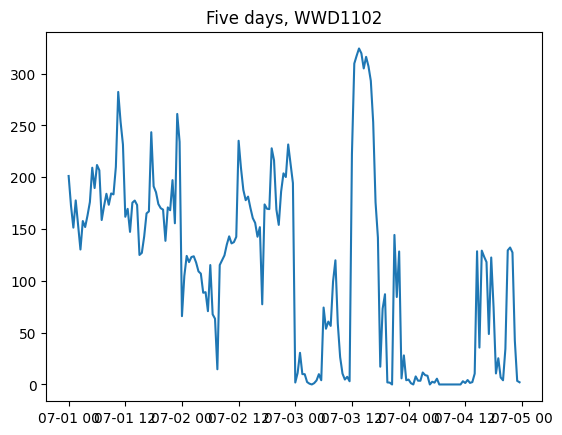

In [29]:
plt.plot(df_zoomed["start_time"], df_zoomed["DollarsPerMegawattHour"])
plt.title("Five days, WWD1102")

## EDA for Windspeed and Rainfall

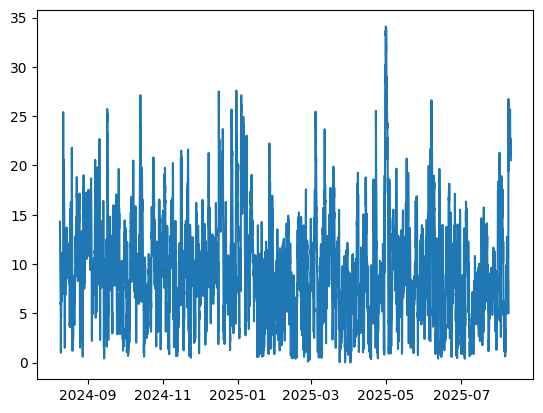

In [30]:
plt.plot(df_all_features["start_time"], df_all_features["speed"])

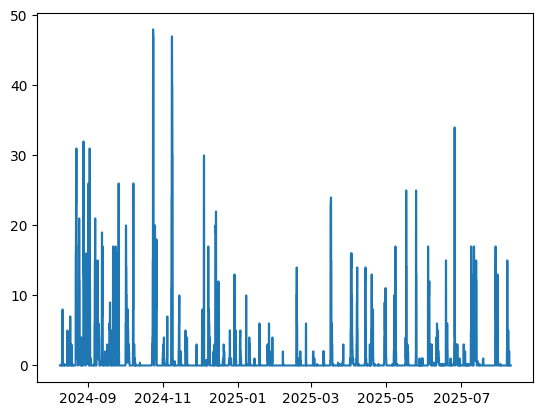

In [31]:
plt.plot(df_all_features["start_time"], df_all_features["rain"])

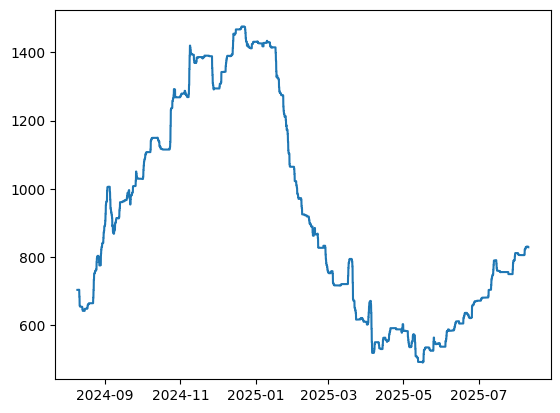

In [32]:
plt.plot(df_all_features["start_time"], df_all_features["rain_cumulative"])

## Filling Missing Values
There are 35 trading periods where there are missing values for DollarsPerMegawattHour.

In [33]:
df_all_features.isna().sum()

date                       0
TradingPeriod              0
start_time                 0
end_time                   0
DollarsPerMegawattHour    35
rain                       0
rain_cumulative            0
speed                      0
dtype: int64

In [34]:
df_all_features = df_all_features.set_index("start_time")

df_all_features["DollarsPerMegawattHour"] = (
    df_all_features["DollarsPerMegawattHour"]
    .interpolate(method="time")
)

df_all_features.reset_index(inplace=True)

In [35]:
df_final = df_all_features.copy()

## Split into a train and test set

## Cross-validation - TimeSeriesSplit

To avoid data leakage, we should split into train and test sets before doing any more EDA. When dealing with time series data, we cannot train on future observations (otherwise the test accuracy would be biased). SKLearn provides the function `TimeSeriesSplit` to perform a 'rolling window evaluation'. This is essentially time-based cross validation. Rolling window evaluation differs from sliding window evaluation, which increments the training set forward by one observation each window - evaluating every subset of train/test data. This is only appropriate for small datasets as it gets computationally expensive on large datasets.

Strategy:
- Get one years worth of data
- Perform EDA on the first six months
- Do a cross validation TimeSeriesSplit

In actuality, we would rather train on a full years worth of data as this would include information about the previous season in the training data. This is important as the usage of electricity is likely to fluctuate with the seasons. However, there were technical issues extracting data from 2023 from emi. For this exercise, only using six months of training data is okay.

In [36]:
# first six months
df_eda = df_final[(df_final["start_time"] < df_final["start_time"].min() + pd.Timedelta(days=180))]
df_train = df_final[(df_final["start_time"] > df_final["start_time"].min() + pd.Timedelta(days=180))]

This chart of five days worth of pricing data shows that wholesale electricity price is very dynamic, ranging from \\$0 to over \\$300 per MWH. There also isn't a simple seasonal pattern. It is interesting that the price will sometimes go to $0 - I am unsure if this is an error in the dataset, or where electricity is surplus to demand and therefore the price drops to 0.

In [37]:
def time_series_split_by_timerange(df, jump_length="1D", window_size_length="1D", time_col="start_time"):
    df = df.sort_values(time_col)
    window_size = pd.Timedelta(window_size_length)
    jump_size = pd.Timedelta(jump_length)

    start_time = df[time_col].min() + window_size
    end_time = df[time_col].max()

    splits = []

    while start_time + jump_size <= end_time:
        train_idx = df[(df[time_col] < start_time) & (df[time_col] > start_time - window_size)].index
        test_idx = df[(df[time_col] >= start_time) & (df[time_col] < start_time + jump_size)].index
        if len(test_idx) == 0:
            break
        splits.append((train_idx, test_idx))
        start_time += jump_size
    return splits

def get_data(df, split):
    return df.iloc[split[0]], df.iloc[split[1]]

# Fitting an ARIMA model

I wanted to define a window which trains using the past six months, and evaluates (and slides by) one month. `TimeSeriesSplit` is not capable of this, so I had to write my own function instead.

This function allows you to define a custom "training length" and "sliding window length".

## Augmented Dickey-Fuller (ADF) test for Stationary time series

An ARIMA model will only work with a stationary time series.

- A stationary time series has constant statistical properties over time.
- The ADF test checks for a unit root. A unit root is characteristic of non-stationary data.
- A 'unit root' would mean that a shock to the series has a permanent effect (i.e. the series would drift over time and not revert to the mean. This is not characteristic of stationary data...).
- A small p-value would indicate a stationary time series.
- To apply an ARIMA model, the time series should be differenced until the time series is stationary.

In [38]:
from statsmodels.tsa.stattools import adfuller

In [39]:
adf_test = adfuller(df_train["DollarsPerMegawattHour"])

In [40]:
# find the p-value
adf_test[1]

np.float64(0.001435094985603007)

The p-value is very small, so we can reject the null hypothesis (the series has a unit root) and claim that the time series is stationary without differencing. This means the `d` parameter for ARIMA is 0.

## Parameters `p` and `q`

- Parameter `p` represents the correlation between $y_t$ and $y_{t-k}$ after removing the effects of lags $1, 2, ..., k-1$. This can be found using the partial-autocorrelation function, and observing when a sharp drop is found.
- Parameter `q` represents the correlation between $y_t$ and $y_{t-k}$ for all lags of `k`. A suitable value for the `q` parameter is found where there is a significant drop in this function.

In [41]:
splits = time_series_split_by_timerange(df_train)

## Part 1: Fit ARIMA

We are doing this on the EDA set because...

In [42]:
# work on df_train to mitigate data leakage
series_eda = df_eda[["start_time", "DollarsPerMegawattHour"]]

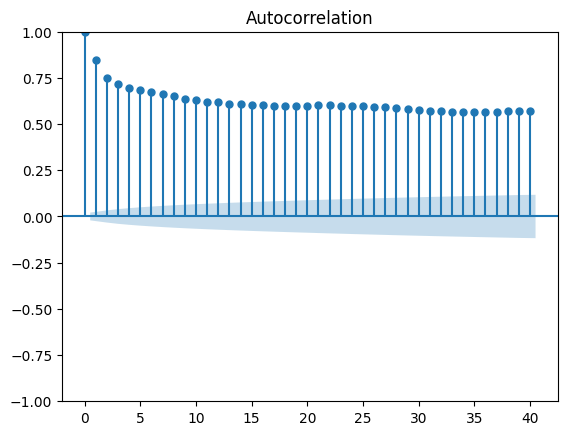

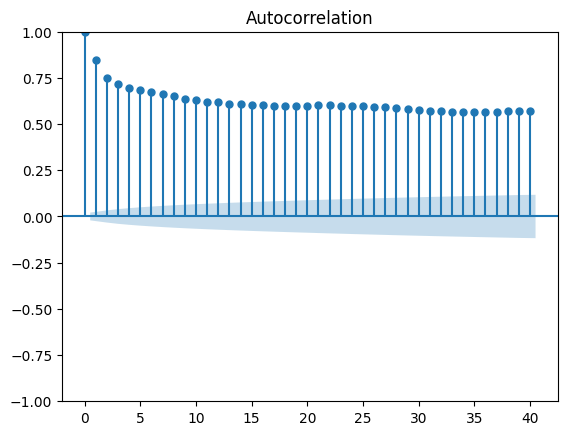

In [43]:
# autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_eda["DollarsPerMegawattHour"], lags=40)

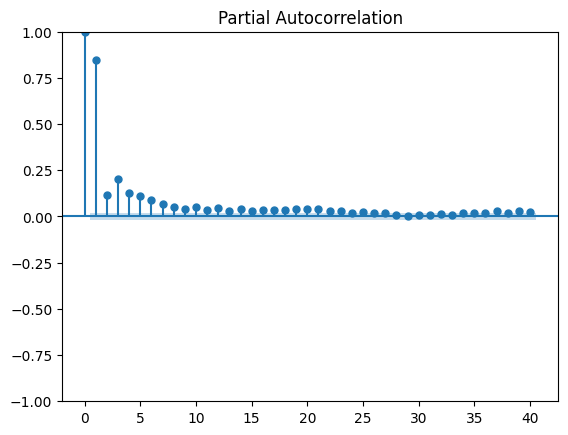

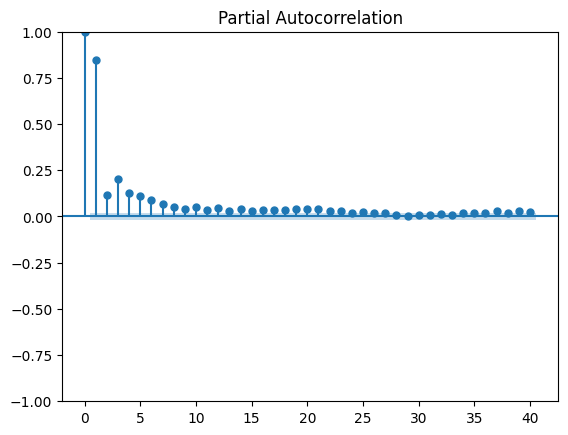

In [44]:
plot_pacf(df_eda["DollarsPerMegawattHour"], lags=40)

In [45]:
p = 2
d = 2
q = 0

In [46]:
datasets = time_series_split_by_timerange(df_final)

In [47]:
class ChartOutput:
    def __init__(self, train, test, model):
        self.train = train
        self.test = test
        self.model = model

In [48]:
# surpressing warnings generated because of the timestamp index. I correctly spaced it manually.
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")


In [49]:
from statsmodels.tsa.arima.model import ARIMA

outputs = []

for dataset in datasets:
    train_idx, test_idx = dataset

    train_set = df_final.iloc[train_idx]
    test_set = df_final.iloc[test_idx]

    model = ARIMA(train_set["DollarsPerMegawattHour"], order=(p, d, q))

    outputs.append(ChartOutput(train_set, test_set, model))


In [50]:
def evaluate_timeseries(outputs, forecast_steps=12, plot_context_steps = 24, test_plot_steps = 12, plot_limit = 5, exog=None):

    count = 0

    all_one_step_errors = []
    all_multi_step_errors = []

    for i, out in enumerate(outputs, start=1):

        do_plot = True

        if count >= plot_limit:
            do_plot = False

        train_set, test_set, model = out.train, out.test, out.model

        train_set = train_set.set_index("start_time")
        test_set = test_set.set_index("start_time")

        res = model.fit()

        forecast_steps_adj = min(forecast_steps, len(test_set))

        if exog is not None:
            forecast = res.forecast(steps=forecast_steps_adj, exog=test_set[exog].iloc[:forecast_steps_adj])
        else:
            forecast = res.forecast(steps=forecast_steps_adj)

        forecast_index = test_set.index[:forecast_steps_adj]
        forecast.index = forecast_index

        y_true = test_set["DollarsPerMegawattHour"].iloc[:forecast_steps_adj]
        y_pred = forecast

        one_step_true = y_true.iloc[0]
        one_step_pred = y_pred.iloc[0]

        all_one_step_errors.append((one_step_true - one_step_pred) ** 2)
        all_multi_step_errors.extend((y_true - y_pred) ** 2)

        if forecast_index[0] - train_set.index[0] < pd.Timedelta(minutes=30*plot_context_steps):
            plot_start = train_set.index[0]
        else:
            plot_start = forecast_index[0] - pd.Timedelta(minutes=30*plot_context_steps)

        train_plot = train_set[train_set.index >= plot_start]
        test_plot = test_set[test_set.index >= plot_start].iloc[:test_plot_steps]

        if do_plot:
            plt.figure(figsize=(12,6))
            plt.plot(train_plot.index, train_plot["DollarsPerMegawattHour"], label="Train", color="blue")
            plt.plot(test_plot.index, test_plot["DollarsPerMegawattHour"], label="Test", color="black")
            plt.plot(forecast.index, forecast, label="Forecast", color="red", linestyle="--")

            plt.scatter(forecast.index[0], forecast.iloc[0], color="green", s=80, zorder=5, label="One-step ahead prediction")
            plt.scatter(test_plot.index[0], test_plot["DollarsPerMegawattHour"].iloc[0], color="yellow", s=80, zorder=5, label="One-step ahead truth")


            plt.title(f"ARIMA Forecast vs Test Set (Model {i})")
            plt.xlabel("Time")
            plt.ylabel("Dollars per MWh")
            plt.legend()
            plt.tight_layout()
            plt.show()

        count += 1

    one_step_mse = np.mean(all_one_step_errors)
    one_step_rmse = np.sqrt(one_step_mse)

    multi_step_mse = np.mean(all_multi_step_errors)
    multi_step_rmse = np.sqrt(multi_step_mse)

    print("Forecast Performance:")
    print(f"One-step ahead MSE: {one_step_mse:.4f}")
    print(f"One-step ahead RMSE: {one_step_rmse:.4f}")
    print(f"Multi-step MSE: {multi_step_mse:.4f}")
    print(f"Multi-step RMSE: {multi_step_rmse:.4f}")

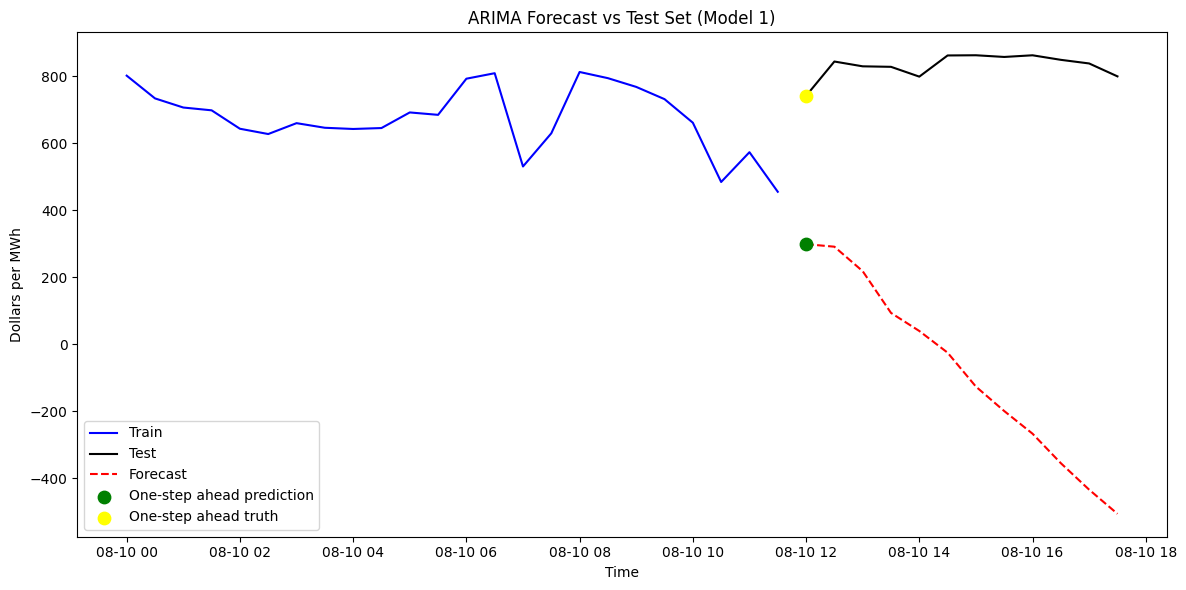

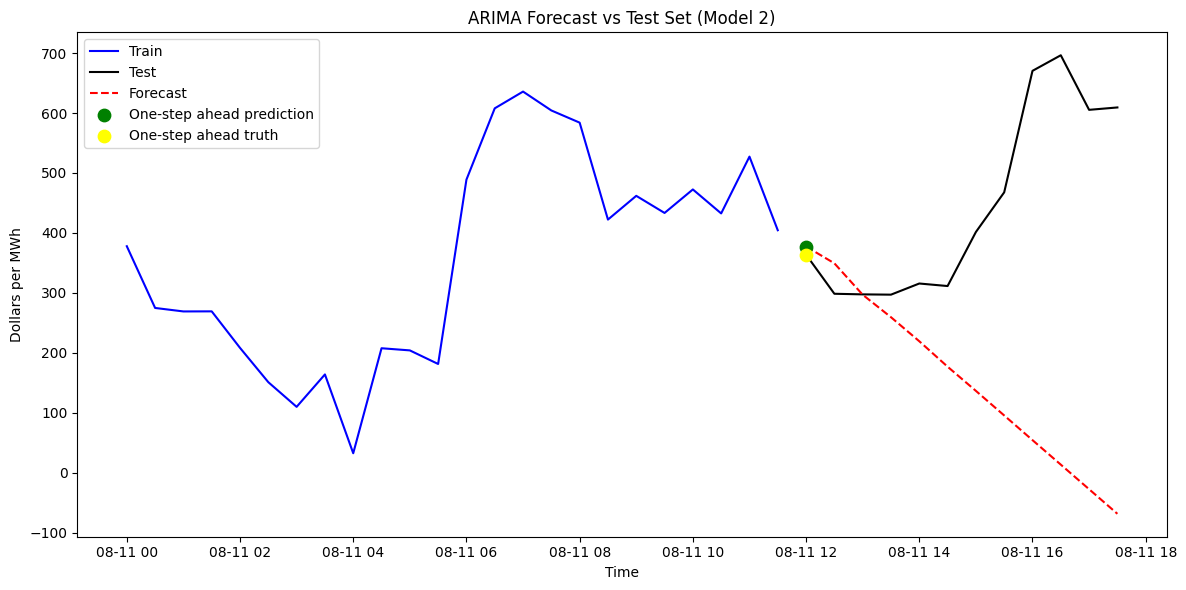

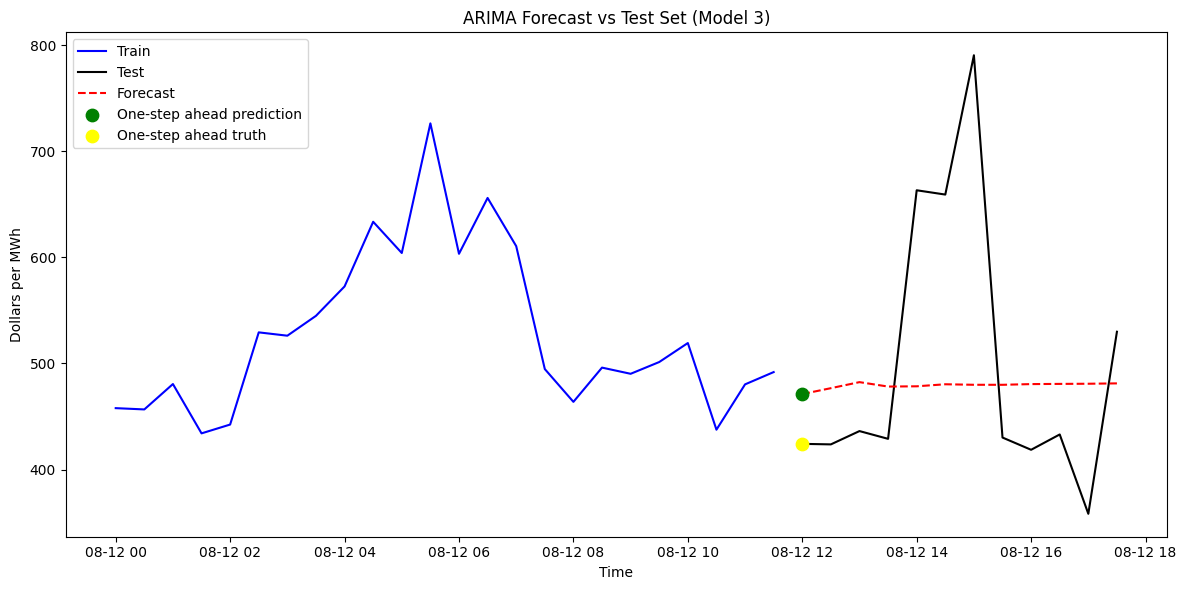

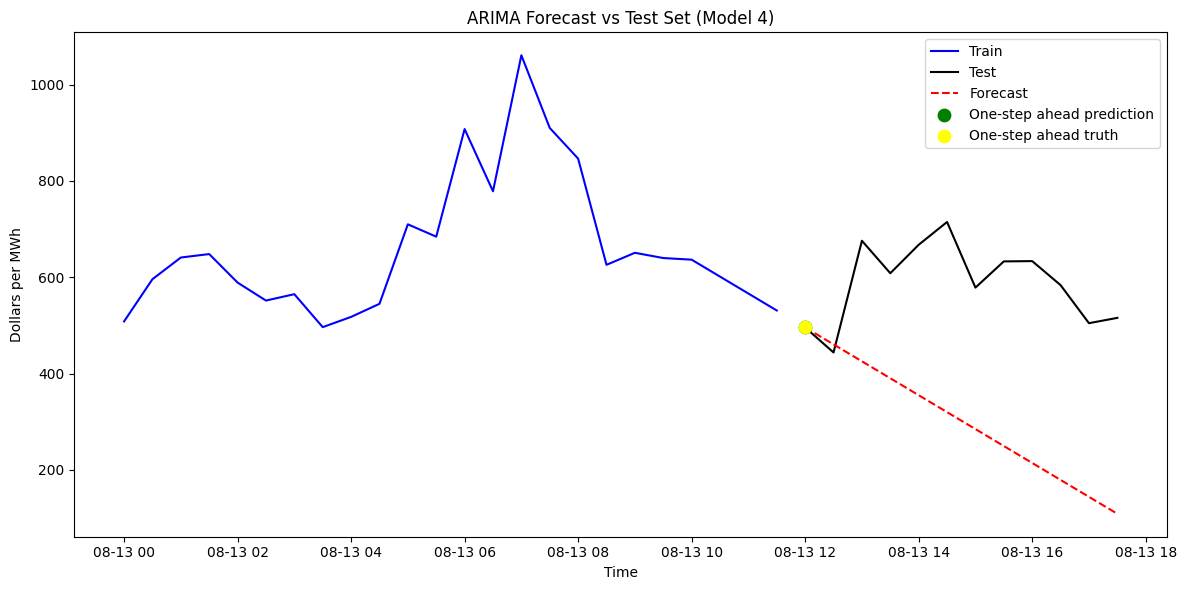

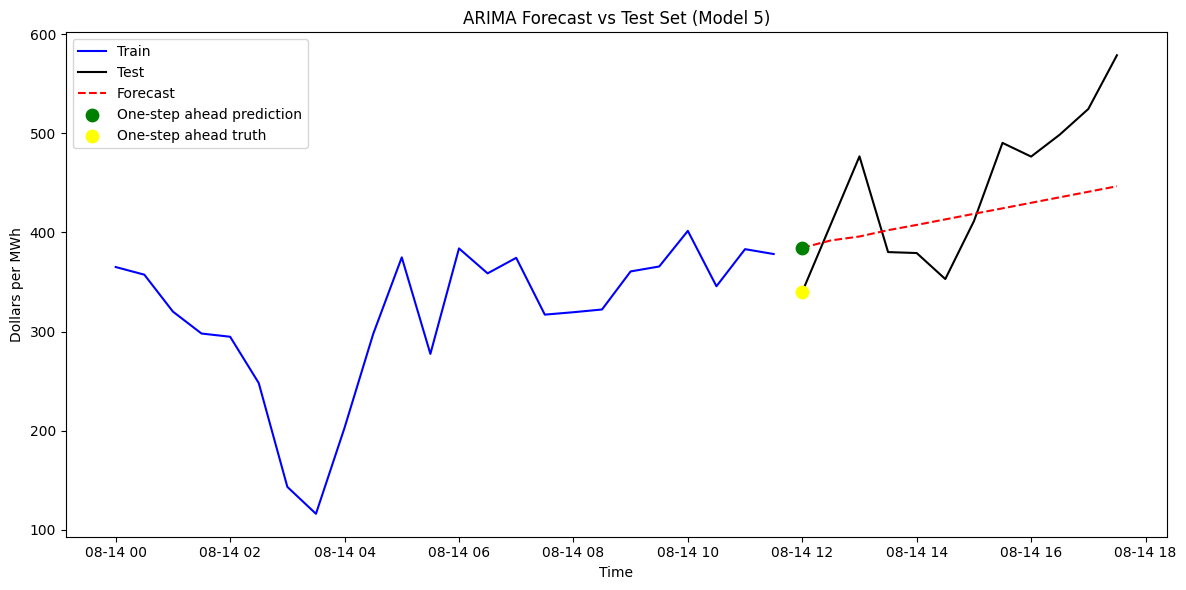

Forecast Performance:
One-step ahead MSE: 11276.1377
One-step ahead RMSE: 106.1892
Multi-step MSE: 1336851.1654
Multi-step RMSE: 1156.2228


In [51]:
evaluate_timeseries(outputs)

## Fitting ARIMAX



In [52]:
outputs_arimax = []

vars = ["speed", "rain", "rain_cumulative"]

for dataset in datasets:
    train_idx, test_idx = dataset

    train_set = df_final.iloc[train_idx]
    test_set = df_final.iloc[test_idx]

    model = ARIMA(train_set["DollarsPerMegawattHour"], exog=train_set[vars], order=(p, d, q))

    outputs_arimax.append(ChartOutput(train_set, test_set, model))

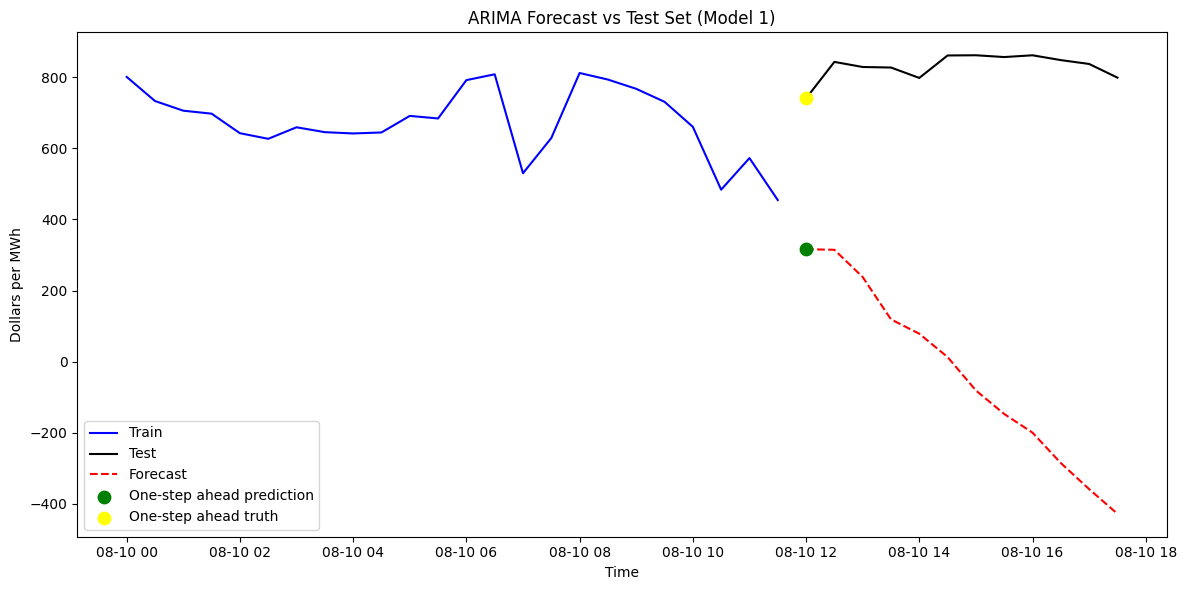

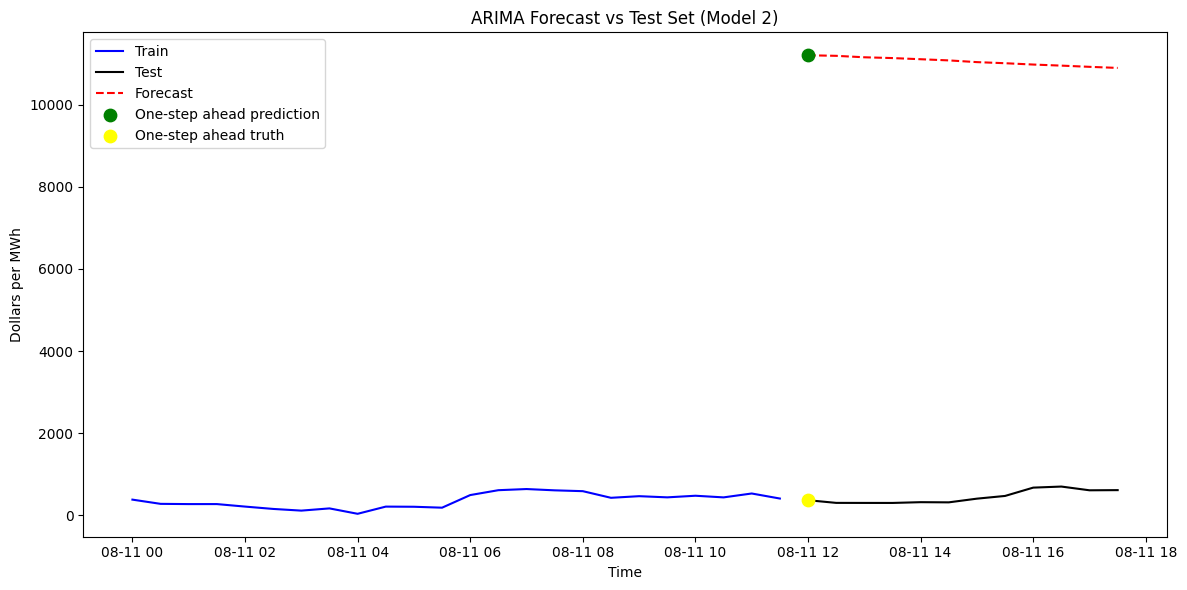

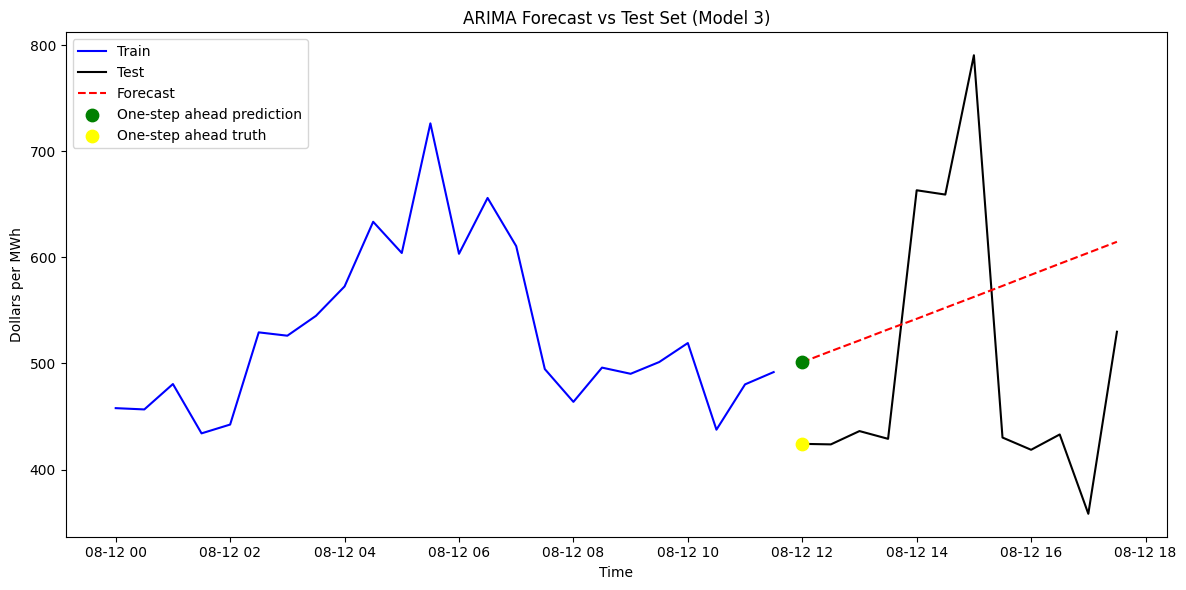

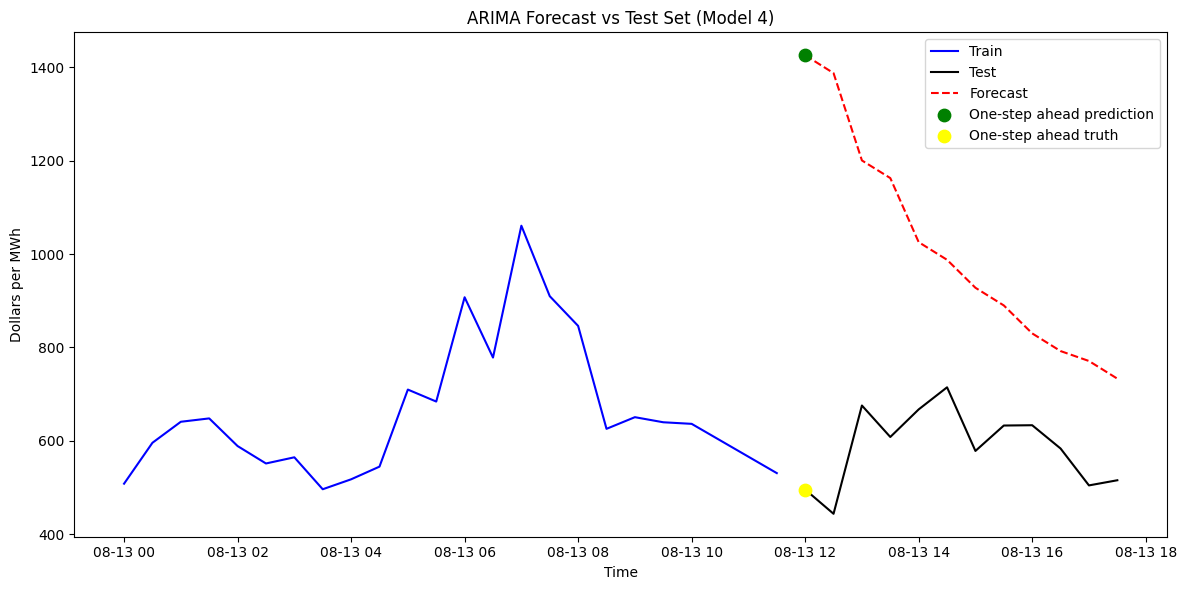

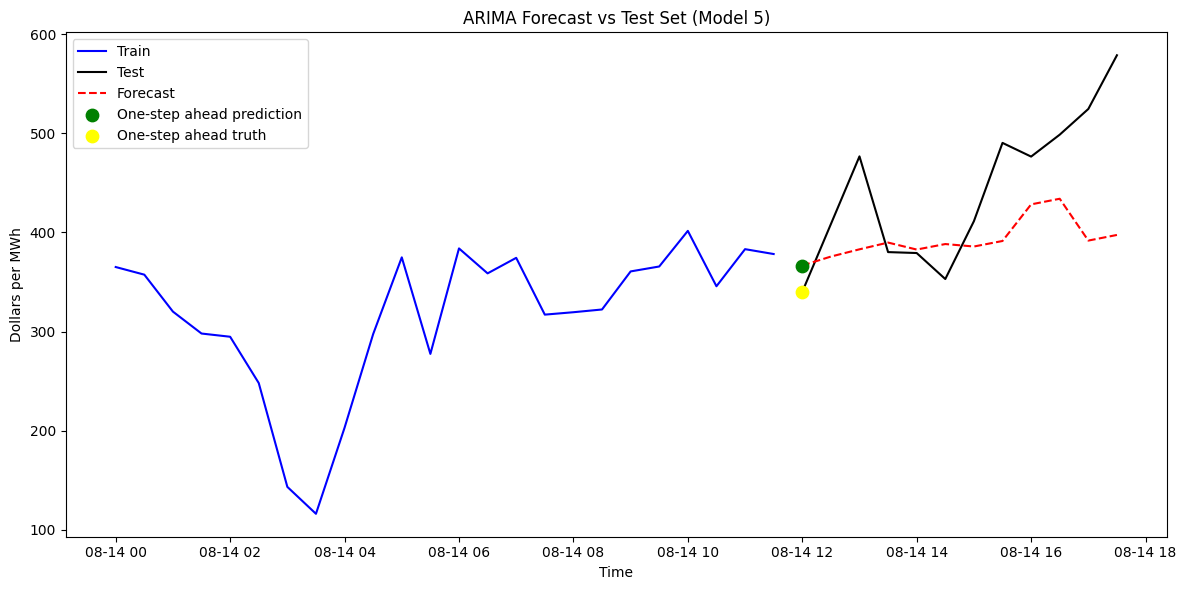

Forecast Performance:
One-step ahead MSE: 9650532.8876
One-step ahead RMSE: 3106.5307
Multi-step MSE: 10544891.2998
Multi-step RMSE: 3247.2898


In [53]:
evaluate_timeseries(outputs_arimax, exog=vars)

## Forecasting with TsFresh

In [201]:
from tsfresh.feature_extraction import extract_features, settings

X_vars = ["id", "start_time", "DollarsPerMegawattHour", "speed", "rain", "rain_cumulative"]
y_var = "DollarsPerMegawattHour"

split_idx = int(len(df_final) * 0.8)
df_train = df_final.iloc[:split_idx]
df_test = df_final.iloc[split_idx:]

def make_windowed_dataset(df, forecast_steps=1, intervals_preceding_length=7*48, jump=10):
    """Turn a continuous time series into tsfresh-ready windows."""
    windowed_dfs = []
    y_values = []
    ids = []
    pred_times = []

    for i, pos in enumerate(range(0, len(df) - intervals_preceding_length - forecast_steps, jump)):

        x_end_idx = pos + intervals_preceding_length
        y_end_idx = pos + intervals_preceding_length + forecast_steps

        window = df.iloc[pos:x_end_idx].copy()
        anchor_time = df.iloc[x_end_idx]["start_time"]
        pred_time = df.iloc[y_end_idx]["start_time"]

        window["id"] = anchor_time
        windowed_dfs.append(window[X_vars])

        y_values.append(df.iloc[y_end_idx][y_var])
        ids.append(anchor_time)
        pred_times.append(pred_time)

    return (
        pd.concat(windowed_dfs),
        pd.Series(y_values, index=ids),
        pd.Series(pred_times, index=ids, name="prediction_time")
    )

In [205]:
from numpy import random
from sklearn.metrics import mean_squared_error

def test_model(df_train, df_test, model, lookahead=1, samples=5, context=48, future=24, name="Unnamed Model"):

    df_train_windows, y_train, train_pred_times = make_windowed_dataset(df_train, forecast_steps=lookahead)
    X_train = extract_features(
        df_train_windows,
        column_id="id",
        column_sort="start_time",
        default_fc_parameters=settings.MinimalFCParameters()
    )

    df_test_windows, y_test, test_pred_times = make_windowed_dataset(df_test, forecast_steps=lookahead)
    X_test = extract_features(
        df_test_windows,
        column_id="id",
        column_sort="start_time",
        default_fc_parameters=settings.MinimalFCParameters()
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)

    print(f"Results for {name}:")
    print(f"MSE = {mse}")
    print(f"RMSE = {rmse}")

    maxidx = len(X_test) - 1

    for i in random.randint(0, len(X_test)-1, samples):
        anchor_time = X_test.index[i]          # end of lookback
        prediction_time = test_pred_times.iloc[i]  # actual forecast timestamp
        prediction = preds[i]
        true = y_test.iloc[i]

        df_context = df_test[df_test["start_time"] <= anchor_time].tail(context).set_index("start_time")["DollarsPerMegawattHour"]
        df_future = df_test[df_test["start_time"] >= anchor_time].head(future+lookahead).set_index("start_time")["DollarsPerMegawattHour"]

        plt.figure(figsize=(10,4))
        plt.plot(df_context.index, df_context.values, label="Context")
        plt.plot(df_future.index, df_future.values, label="Future")
        plt.plot(prediction_time, prediction, 'ro', label="Prediction")
        plt.plot(prediction_time, true, 'bo', label="True")
        plt.axvline(anchor_time, color="gray", linestyle="--", alpha=0.5)
        plt.legend()
        plt.title(f"Sample {i} prediction | {name}")
        plt.show()

        #print(f"MSE: {this_mse} \n RMSE: {this_rmse}")

## Linear Regression

In [206]:
# forecasting the first step ahead with linear regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

regression_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression())
    ])

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


Results for Linear Regression, Lookahead = 1:
MSE = 4700.569710181547
RMSE = 68.56070091664427


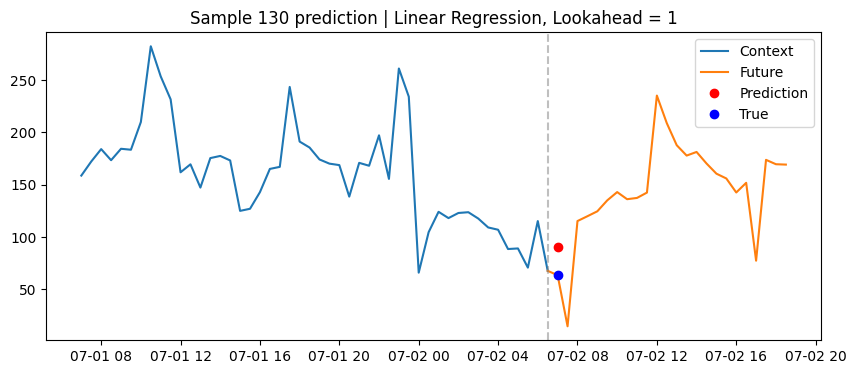

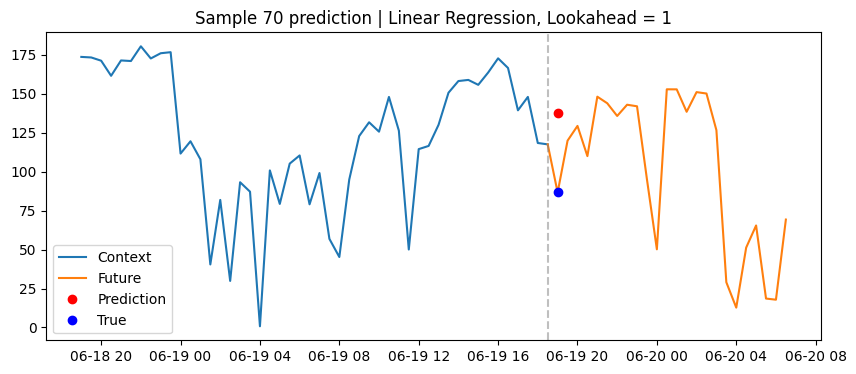

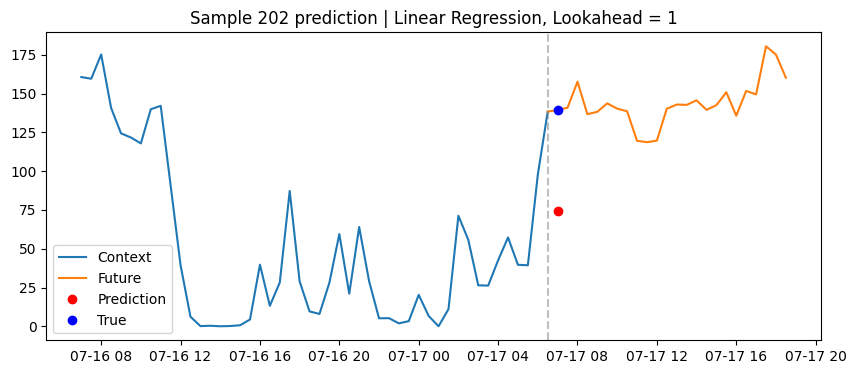

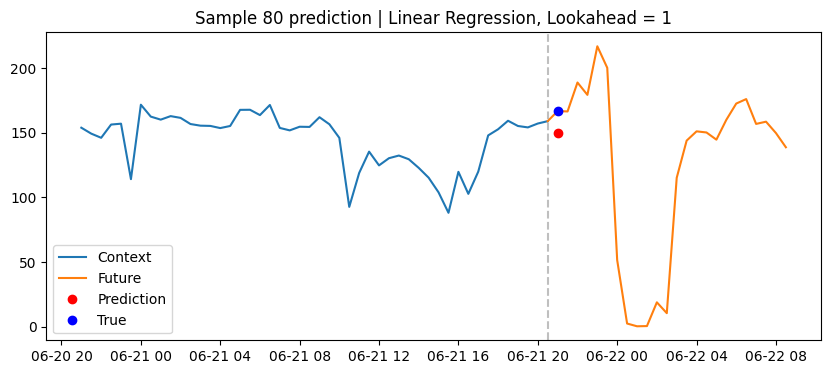

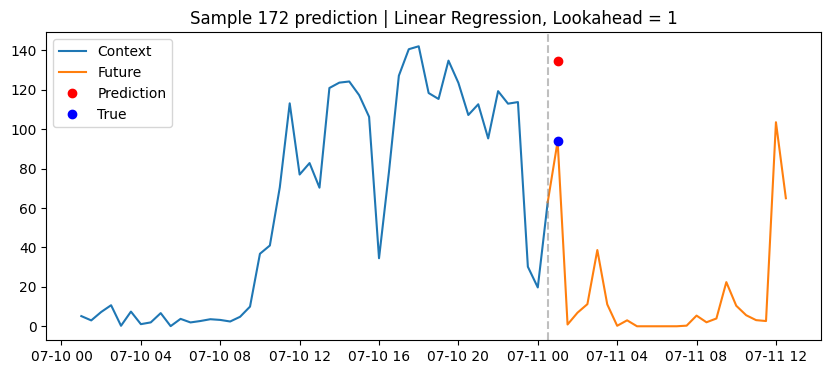

In [207]:
test_model(df_train, df_test, regression_pipeline, lookahead=1, name="Linear Regression, Lookahead = 1")

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Results for Linear Regression, Lookahead = 12:
MSE = 4441.597119636321
RMSE = 66.64530830926


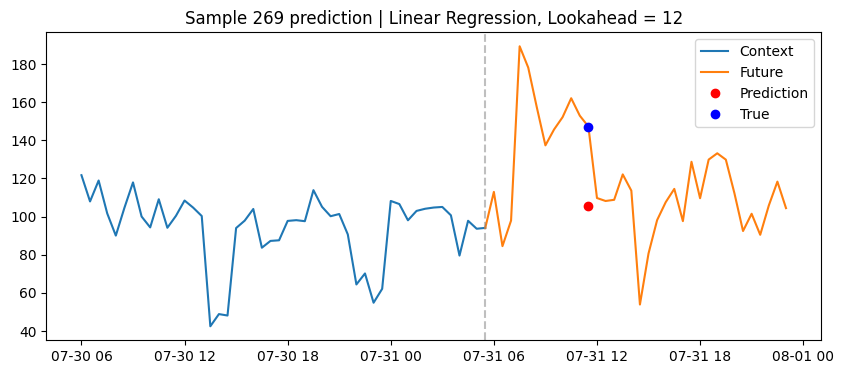

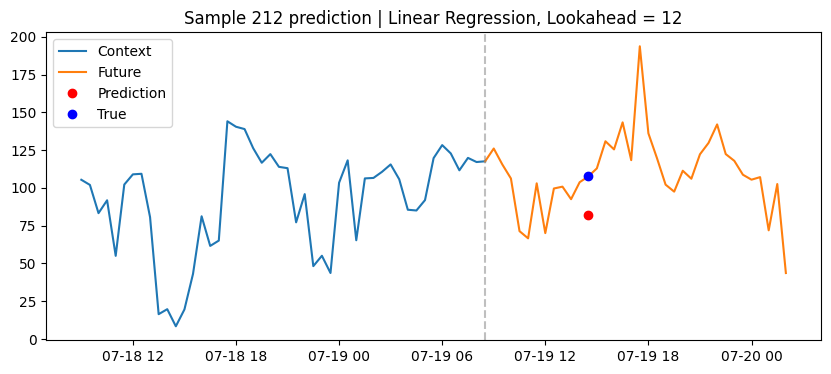

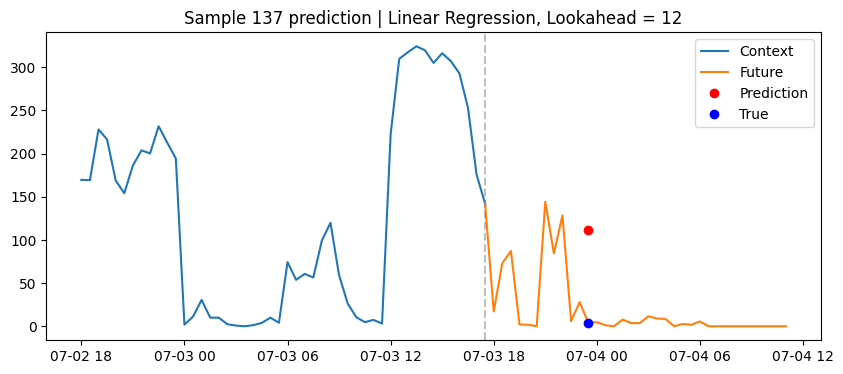

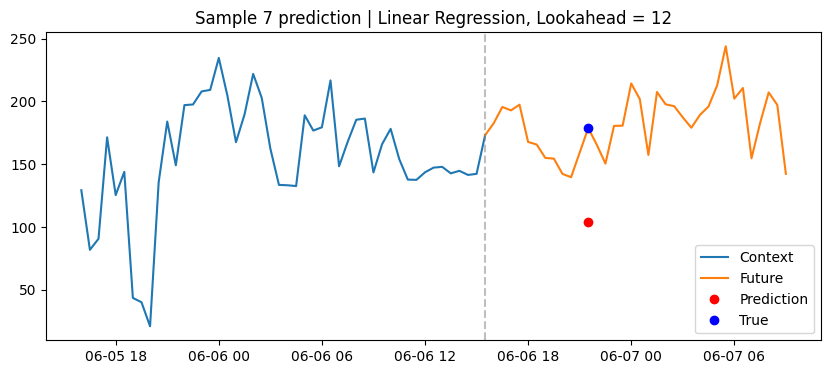

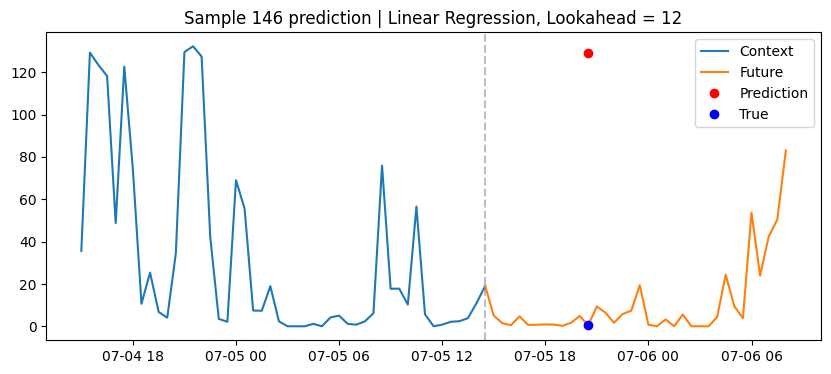

In [208]:
test_model(df_train, df_test, regression_pipeline, lookahead=12, name="Linear Regression, Lookahead = 12")

## Random Forest Regressor

In [210]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
        ("regressor", RandomForestRegressor())
    ])

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Results for Random Forest Regression, Lookahead = 1:
MSE = 4201.761134528186
RMSE = 64.8209930078843


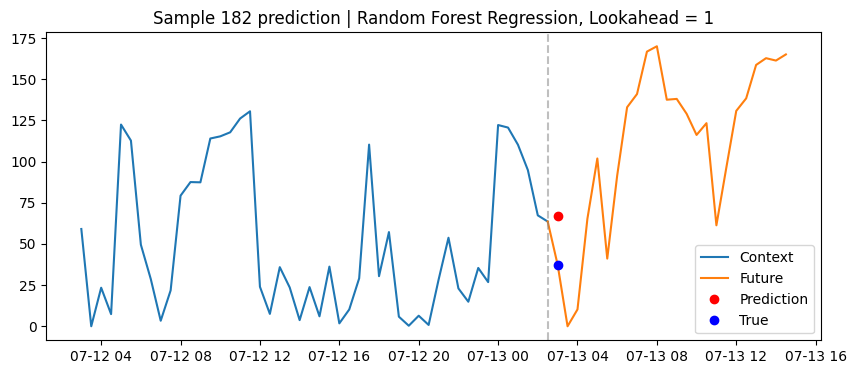

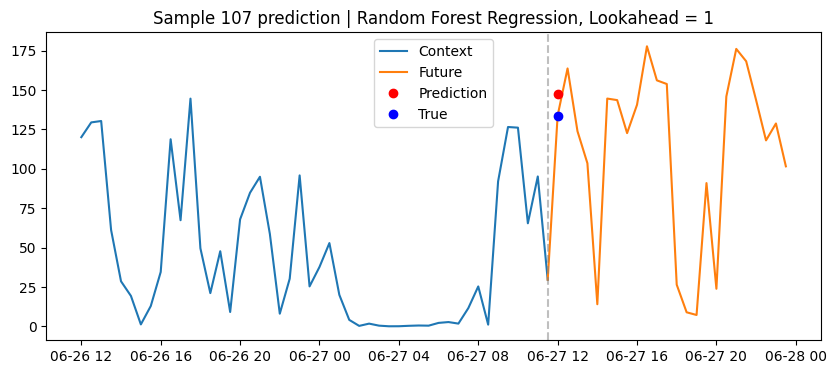

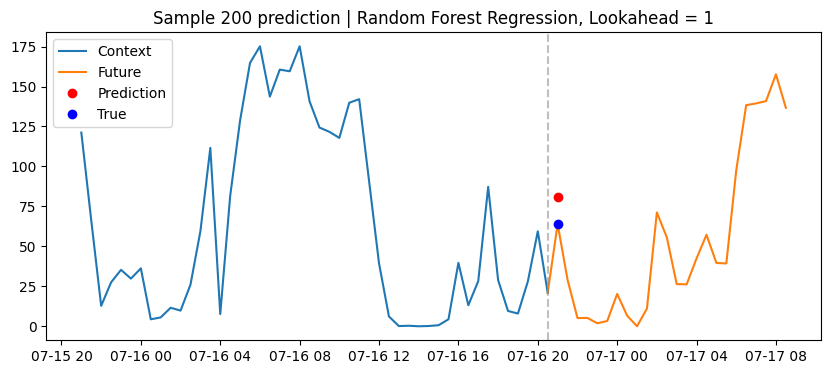

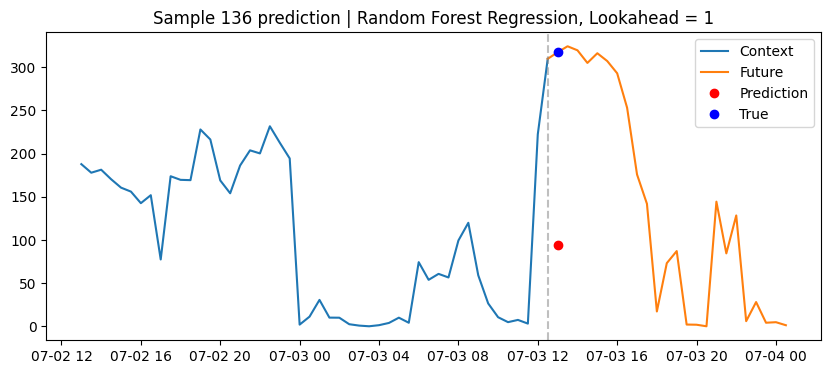

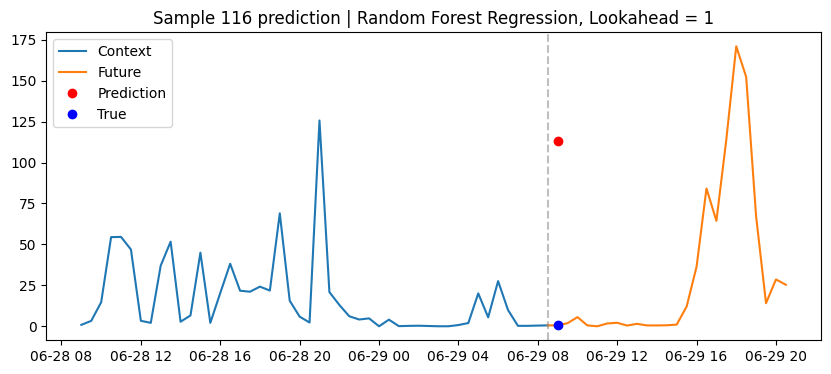

In [211]:
test_model(df_train, df_test, rf_pipeline, lookahead=1, name="Random Forest Regression, Lookahead = 1")